FORCAST Basic Photometry
=================
* **Aim**: Simple aperture photometry and uncertainty calculation. <br />
* **Data**: FORCAST imaging data (5.6um) of the Symbiotic Mira, HM Sge <br />
* **Tools**: astropy, photutils <br />
* **Instrument**: FORCAST<br />
* **Documentation**: [FORCAST data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf)

## Goals
* Determine the sum of the flux within an aperture .
* Determine the sum of flux within a larger annulus for background determination.
* Subtract background flux.
* Calculate uncertainty.

Introduction
-------------
This turotial will go through the basic process of aperture photometry for a single source using `python` and `astropy`. For a more in-depth description of each of these steps refer to the FORCAST photometry (detailed) tutorial. For further instructions on this process refer to the FORCAST data handbook referenced above.  

## Imports

In [1]:
from astropy import units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from photutils.aperture import (
    CircularAperture,
    CircularAnnulus,
    aperture_photometry,
)
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Ingredients
------------

The data used are Level 3 flux calibrated imaging data for a [public dataset](https://www.stsci.edu/hst/proposing/approved-programs/hst-sofia) targeting the Symbiotic Mira, HM Sge, in FORCAST's 5.6 $\mu$m filter. Access to this, and other, data can be found at the Infrared Science Archive [(IRSA)](https://irsa.ipac.caltech.edu/Missions/sofia.html).

#### The data can be directly downloaded [here](https://zenodo.org/record/6574619/files/F0753_FO_IMA_7500575_FORF056_CAL_0109-0111.fits?download=1)


In [2]:
# Load the data
filename = "example_data/FORCAST/F0753_FO_IMA_7500575_FORF056_CAL_0109-0111.fits"
data = fits.open(filename)
hdr = data[0].header
w = WCS(data[0].header)

In [3]:
# print first 30 rows
hdr[0:30]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  296                                                  
NAXIS2  =                  334                                                  
EXTEND  =                    T                                                  
COMMENT / -- scaling --                                                         
COMMENT / --- DCS OBSERVATION ---                                               
DATASRC = 'astro   '           / (DCS) data source                              
OBSTYPE = 'OBJECT  '           / Observation type                               
SRCTYPE = 'UNKNOWN '           / pipeline source type                           
KWDICT  = 'DCS_SI_rev_F'       / FITS keyword dictionary version                
OBS_ID  = 'P_2021-07-01_FO_F

## Get aperture radius sum
The background annulus should be as large as possible without including other sources or large variations to ensure good statistics. We recommend using the same aperture and annulus as used for calibrators (12 pixels). It is also recommended to use a background annulus of 15-25 pixels so long as this does not include additional sources of flux. 

```diff
- Warning: An aperture radius of 12 may not be appropriate for your observations. Consult the FORCAST handbook if you are not sure. 
```


In [4]:
# Aperture sum function
def get_aperture_sum(data, pos_pix, r_pix):
    pix_aperture = CircularAperture(pos_pix, r=r_pix)
    sum_aperture = aperture_photometry(data[0].data, pix_aperture)
    area = pix_aperture.area
    return sum_aperture["aperture_sum"], pix_aperture, area

In [5]:
# USER OPTIONS______________
r_ap = 12
background_aperture_inner_radius = 15.0
background_aperture_outter_radius = 25.0

target_ra = "19:41:57.080"
target_dec = "16:44:39.64"
# _________________________

In [6]:
# get position in SkyCoord format
pos = SkyCoord(target_ra, target_dec, unit=(u.hourangle, u.deg))

# convert to pixels within data
pos_pix = pos.to_pixel(w)

# determine sum flux at pixel position and with aperature radius: r_ap
sum_jy, pix_aperture, area = get_aperture_sum(data, pos_pix, r_ap)

## Define background annulus

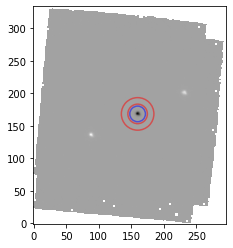

In [7]:
# get WCS information of data
w = WCS(data[0].header)

# define background annulus of similar center and specified radii
annulus_aperture = CircularAnnulus(
    pos_pix,
    r_in=background_aperture_inner_radius,
    r_out=background_aperture_outter_radius,
)

# plot aperture and annulus
plt.imshow(data[0].data, cmap="gray_r", origin="lower")
pix_aperture.plot(color="blue", lw=1.5, alpha=0.5)
annulus_aperture.plot(color="red", lw=1.5, alpha=0.5);

Two other white artifacts can also be seen in this image. These are artifacts of the stacking and the specific merging procedure and should not be used for further anaylsis.

## Calculate and subtract background flux

In [8]:
# determine flux sum within background annulus
bkg_results = aperture_photometry(data[0].data, annulus_aperture)

# determine flux average in background annulus
bkg_mean = bkg_results["aperture_sum"] / annulus_aperture.area

# subtract background average from flux sum within aperture.
flux_background_subtracted = sum_jy[0] - bkg_mean[0]

print("Flux removed: " + "{:.6f}".format(bkg_mean[0]) + " Jy")
print("background_substracted flux: " + "{:.6f}".format(flux_background_subtracted) + " Jy")

Flux removed: 0.001054 Jy
background_substracted flux: 52.810753 Jy


## Calculate relative uncertainty

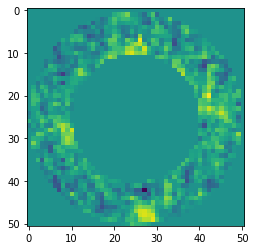

In [9]:
# create annulus mask from previously created annulus aperture
annulus_mask = annulus_aperture.to_mask(method="center")

# applying mask to data
annulus_data = annulus_mask.multiply(data[0].data)

# calculating standard deviation within background annulus
annulus_std = np.std(annulus_data)

# plotting data
plt.imshow(annulus_data);

The error is calculated (in quadrature) using the relative error, the relative error in the flux calibration, and the uncertainty in the flux calibration
model at the given wavelength, which is typically 5% (Dehaes et al. 2011).

More details for this calculation can be found in the FORCAST photometry (detailed) notebook.

In [10]:
# calculating the relative uncertainty (%)
sigma_m = np.sqrt(
    (
        2 * np.pi * (r_ap * annulus_std / flux_background_subtracted) ** 2 # relative error
        + (hdr["ERRCALF"] / hdr["CALFCTR"]) ** 2 # relative error in flux calibration
        + (0.05) **2 # uncertainty in the flux calibration
    )
)
print('relative uncertainty: '+"{:.2f}".format(sigma_m*100)+'%')

relative uncertainty: 5.59%


r_ap: aperture radius in pixels

CALFCTR: Calibration Factor (Me/sec/Jy)

ERRCALF: Calibration Factor Uncertainty (Me/sec/Jy)

## Calculate final flux + absolute uncertainty

In [11]:
absolute_uncertainty = sigma_m*flux_background_subtracted

print("Final 5.6um flux w/ uncertainty:\n"
    + "{:.6f}".format(flux_background_subtracted)
    + " +/- "
    + "{:.6f}".format(absolute_uncertainty)
    + " Jy"
)

Final 5.6um flux w/ uncertainty:
52.810753 +/- 2.952915 Jy


## For more information different sources of noise and image artifacts, see the excellent review in James Radomski's [SOFIA school webniar](https://www.youtube.com/watch?v=Nrd_w-ZKBrM)